<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/Demo_SBI_HMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --quiet sbi

     |████████████████████████████████| 293 kB 5.3 MB/s 
     |████████████████████████████████| 722 kB 45.2 MB/s 
     |████████████████████████████████| 45 kB 1.1 MB/s 


In [3]:
!pip install --upgrade --quiet numpyro

     |████████████████████████████████| 292 kB 5.2 MB/s 


In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import numpyro

import torch
import pyro
import sbi
from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils

In [2]:
# Replace version 3.2 by 3.5
!pip uninstall -y matplotlib
!pip install -q matplotlib==3.5.0
# Needs Re-initialize the environment then pass to the next cell

Found existing installation: matplotlib 3.5.0
Uninstalling matplotlib-3.5.0:
  Successfully uninstalled matplotlib-3.5.0


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import arviz as az
import matplotlib.patches as mpatches

In [25]:
############
def overplot_lines(axes, xs, reverse=False, **kwargs):
    """
    Overplot lines on a figure generated by ``corner.corner``
    Parameters
    ----------
    fig : Figure
        The figure generated by a call to :func:`corner.corner`.
    xs : array_like[ndim]
       The values where the lines should be plotted. This must have ``ndim``
       entries, where ``ndim`` is compatible with the :func:`corner.corner`
       call that originally generated the figure. The entries can optionally
       be ``None`` to omit the line in that axis.
    reverse: bool
       A boolean flag that should be set to 'True' if the corner plot itself
       was plotted with 'reverse=True'.
    **kwargs
        Any remaining keyword arguments are passed to the ``ax.axvline``
        method.
    """
    K = len(xs)
    if reverse:
        for k1 in range(K):
            if xs[k1] is not None:
                axes[K - k1 - 1, K - k1 - 1].axvline(xs[k1], **kwargs)
            for k2 in range(k1 + 1, K):
                if xs[k1] is not None:
                    axes[K - k2 - 1, K - k1 - 1].axvline(xs[k1], **kwargs)
                if xs[k2] is not None:
                    axes[K - k2 - 1, K - k1 - 1].axhline(xs[k2], **kwargs)

    else:
        for k1 in range(K):
            if xs[k1] is not None:
                axes[k1, k1].axvline(xs[k1], **kwargs)
            for k2 in range(k1 + 1, K):
                if xs[k1] is not None:
                    axes[k2, k1].axvline(xs[k1], **kwargs)
                if xs[k2] is not None:
                    axes[k2, k1].axhline(xs[k2], **kwargs)

def plot_params_kde(samples,hdi_probs=[0.393, 0.865, 0.989], 
                    patName=None, fname=None, pcut=None, reference_values=None, 
                    reference_color='k', label_size=10,labeller=None, limits=None,
                   var_names=None, point_estimate="median", figsize=(8,8)):
    """
     limts = [[min_1,max_1], ... , [min_N, max_N]] N varaibles
    """
        
    if pcut is not None:
        low = pcut[0]
        up  = pcut[1] 
        #keep only data in the [low, up] percentiles ex. 0.5, 99.5
        samples={name:value[(value>np.percentile(value,low)) &  (value<np.percentile(value,up))] \
          for name, value in samples.items()}
        len_min = np.min([len(value) for name, value in samples.items()])
        len_max = np.max([len(value) for name, value in samples.items()])
        if (len_max-len_min)>0.01*len_max:
            print(f"Warning: pcut leads to min/max spls size = {len_min}/{len_max}")
        samples = {name:value[:len_min] for name, value in samples.items()}
    
    axs= az.plot_pair(
            samples,
            var_names=var_names,
            kind="kde",
            labeller=labeller,
            figsize=figsize,
            marginal_kwargs={"plot_kwargs": {"linewidth": 2, "c": "b"}},
            kde_kwargs={
#                "hdi_probs": [0.68, 0.9],  # Plot 68% and 90% HDI contours
                "hdi_probs":hdi_probs,  # 1, 2 and 3 sigma contours
                "contour_kwargs":{"colors":('r', 'green', 'blue'), "linewidths":2},
                "contourf_kwargs":{"alpha":0},
            },
            point_estimate_kwargs={"lw": 2, "c": "b"},
            marginals=True, textsize=label_size, point_estimate=point_estimate,
            reference_values=reference_values, reference_values_kwargs={"c":reference_color}
        );
    
    if reference_values is not None:
      overplot_lines(axs,list(reference_values.values()), color=reference_color)
      if limits is not None:
        assert len(limits) == len(samples.keys()), "wrong number of limits"
        for i in range(0,axs.shape[0]):
          for j in range(0,i+1):
            if j == i:
              axs[i,i].set_xlim(limits[i])
            else:
              axs[i,j].set_xlim(limits[j])
              axs[i,j].set_ylim(limits[i])

    plt.tight_layout()
    
    if patName is not None:
#        patName_patch = mpatches.Patch(color='b', label=patName)
#        axs[0,0].legend(handles=[patName_patch], fontsize=40, bbox_to_anchor=(1, 0.7));
      fig = axs[0,0].get_figure()
      fig.suptitle(patName)
    if fname is not None:
        plt.savefig(fname)
        plt.close()
    else:
        plt.show();


In [5]:
#torch, numpy, random seeds set manualy
pyro.set_rng_seed(42)

# Data

In [6]:
N = 50
t = np.sort(np.random.rand(N))

In [7]:
def make_data(theta, t):
    a, mu, sig, b0, b1 = theta

    signal = a * jnp.exp(-(mu-t)**2 / (2*sig**2))
    bkgd  = b0 + b1*t

    return signal + bkgd

In [8]:
theta_true = jnp.array([1, 0.5, 0.1, -0.1, 0.4])
labels = ["a","mu","sig","b0","b1"]
truth = {k:v for k,v in zip(labels, theta_true)}

In [9]:
x_o_noiseless = make_data(theta_true, t)

In [10]:
key = jax.random.PRNGKey(42)
key, subkey  = jax.random.split(key,2)
sig_noise = jax.random.uniform(subkey,shape=(N,), minval=0.05, maxval=0.25) # non constant sigma of noise

In [11]:
key, subkey  = jax.random.split(key,2)
x_o = x_o_noiseless + jax.random.multivariate_normal(subkey, mean=jnp.array([0.]*N), cov=jnp.diag(sig_noise**2))

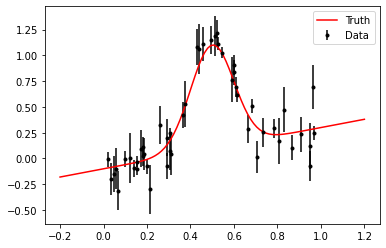

In [12]:
t_full = np.linspace(-0.2,1.2,100)
x_full_no_noise = make_data(theta_true,t_full) 
plt.errorbar(t,x_o,yerr=sig_noise, fmt=".k", capsize=0, label="Data");
plt.plot(t_full, x_full_no_noise,c='r',label="Truth")
plt.legend();

# HMC

In [13]:
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [14]:
#def make_data(theta, t):
#    a, mu, sig, b0, b1 = theta
#
#    signal = a * jnp.exp(-(mu-t)**2 / (2*sig**2))
#    bkgd  = b0 + b1*t
#
#    return signal + bkgd

In [15]:
def model(t, x_o=None, sig_noise=0.1):

    # define parameters with priors
    a = numpyro.sample('a', dist.Uniform(-2, 2))
    mu = numpyro.sample('mu', dist.Uniform(-2, 2))
    sig =  numpyro.sample('sig', dist.InverseGamma(1.0, rate=1.0)) # numpyro.sample('sig', dist.Uniform(0, 2))
    b0 = numpyro.sample('b0', dist.Uniform(-2, 2))
    b1 = numpyro.sample('b1', dist.Uniform(-2, 2))

    # implement the model
    theta = jnp.array([a,mu,sig,b0,b1])
    x = make_data(theta,t)

    # condition the model to the observation x_o
    numpyro.sample('obs', dist.Normal(x, sig_noise), obs=x_o)


In [16]:
key, subkey  = jax.random.split(key,2)

In [17]:
# run HMC with NUTS
kernel = NUTS(model, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(subkey, t=t, x_o = x_o, sig_noise=sig_noise)
mcmc.print_summary()

sample: 100%|██████████| 4000/4000 [00:13<00:00, 303.49it/s, 15 steps of size 2.81e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.07      0.05      1.07      0.99      1.15   2350.36      1.00
        b0     -0.11      0.03     -0.11     -0.16     -0.06   1631.80      1.00
        b1      0.36      0.06      0.36      0.26      0.46   1593.06      1.00
        mu      0.50      0.01      0.50      0.49      0.51   2411.12      1.00
       sig      0.11      0.01      0.11      0.10      0.12   2375.56      1.00

Number of divergences: 0


In [28]:
hmc_spls = mcmc.get_samples()

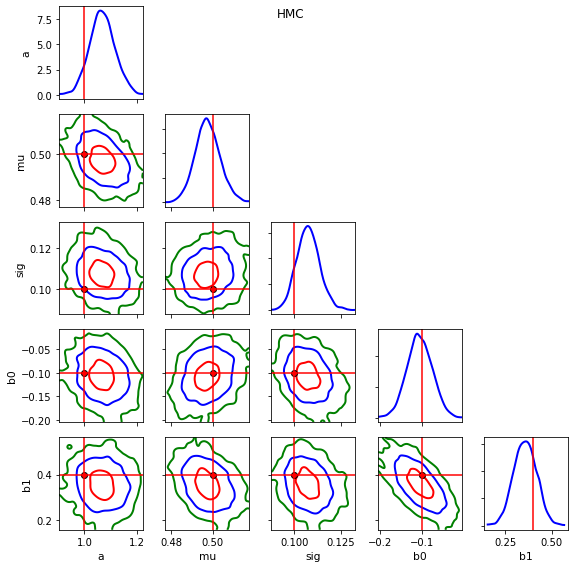

In [29]:
plot_params_kde(hmc_spls,var_names=labels, figsize=(8,8), limits=None,
            point_estimate=None, reference_values=truth, reference_color='r',
            patName="HMC", fname=None);


In [27]:
from numpyro.infer import Predictive

In [30]:
predictive = Predictive(model, posterior_samples=hmc_spls)
# need to set noise to zero
# since the full model contains noise contribution
predictions = predictive(subkey, t=t_full, sig_noise=0.0)['obs']


In [33]:
predictions.shape

(3000, 100)

In [38]:
# select 50 predictions to show
inds = jax.random.randint(subkey, (50,) , 0, mcmc.num_samples)
predictions = predictions[inds]


In [39]:
predictions.shape

(50, 100)

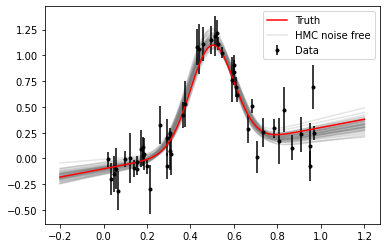

In [50]:
t_full = np.linspace(-0.2,1.2,100)
x_full_no_noise = make_data(theta_true,t_full) 
plt.errorbar(t,x_o,yerr=sig_noise, fmt=".k", capsize=0, label="Data");
plt.plot(t_full, x_full_no_noise,c='r',label="Truth")
for i in range(predictions.shape[0]):
  if i==0:
    tag="HMC noise free"
  else:
    tag=None
  plt.plot(t_full, predictions[i],c="C7",alpha=0.2, zorder=-1,label=tag);
plt.legend();